$\dot{\vec p} = \frac{1}{2\beta}[\vec{k} - (\vec k \cdot \vec p)\vec p] + \frac 1 2 \vec \omega \times \vec p$

$\beta = \mu \alpha /2\rho g h$

$\vec \omega = \nabla \times \vec v_{flow}$

$v_{flow} = Ar + \frac B r \implies \vec \omega = (0, 0, 2A)$ 

$A = \cfrac{-\Omega}{R_2^2/R_1^2-1} \space B = \cfrac{\Omega R_2^2}{R_2^2/R_1^2-1}$

$\dot{\vec R} =  v_0 \vec p + \vec v_{flow}$

Cut-off Lennard-Jones potential

$$ V_W = 
\begin{cases}
    4\varepsilon \left[ (\frac{\sigma_W}{r}) ^{12} - (\frac{\sigma_W}{r}) ^{6}\right] +\varepsilon, \ \text{for} \ r<d^*\\
      0
    \end{cases} $$
$$d^* = 2^{1/6}  \sigma_W =R  \quad \sigma_W = R/2^{1/6}$$
$$ F_W = -\cfrac{\partial V_W}{\partial r}$$


$$\dot{\vec p} = \frac{1}{2\beta}[\vec{k} - (\vec k \cdot \vec p)\vec p] + \frac 1 2 \vec \omega \times \vec p - 2D_Rdt\vec p+ (\vec\eta_R \times \vec p)\sqrt{2D_Rdt}$$
$$\beta = \mu \alpha /2\rho g h,  \vec \omega = \nabla \times \vec v_{flow}, \vec v_{flow} = (-Ay, Ax, 0)$$ 

$$\dot{\vec R} =  v_0 \vec p  + \vec v_{flow} + \mu\vec F_W + \vec\eta_T\sqrt{2D_Tdt} $$

$\gamma = 6\pi\eta R \quad \mu = 1/\gamma$

In [135]:
import numpy as np
from scipy.integrate import odeint
from scipy.spatial import KDTree
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from numba import njit

In [3]:
def data_for_cylinder_along_z(radius, height_z, null_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2 * np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z + null_z)
    x_grid = radius * np.cos(theta_grid)
    y_grid = radius * np.sin(theta_grid)
    return x_grid, y_grid, z_grid



def makesphere(x, y, z, radius, resolution=10):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

In [198]:
def plot_state(coords):
    ax = plt.figure().add_subplot(projection='3d')

    for i in range(len(coords)):
        X, Y, Z = makesphere(coords[i][0], coords[i][1], coords[i][2], R)
        ax.plot_surface(X, Y, Z, color="r")

    X1,Y1,Z1 = data_for_cylinder_along_z(R1, L, 0)
    ax.plot_surface(X1, Y1, Z1, alpha=0.5)

    X2,Y2,Z2 = data_for_cylinder_along_z(R2, L, 0)
    ax.plot_surface(X2, Y2, Z2, alpha=0.5)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.axis('equal');

    plt.show()

In [234]:
def plot_dist(sol, threshold, bins):
    dist = distance_matrix(sol[:][:,-1],sol[:][:,-1])
    ds = dist[np.triu_indices(N, k = 1)]
    ds_short = [d for d in ds if d < threshold]

    fig, axs = plt.subplots(1, 2, figsize = (12,5))
    axs[0].hist(ds, bins = bins,  density=False);
    axs[1].hist(ds_short, bins = bins,  density=False);

    axs[0].set_xlabel('distance between particles')
    axs[1].set_xlabel('distance between particles')

    plt.show()

In [247]:
def plot_angle(sol, bins):
    psi = np.arctan2(sol[:, -1, 1], sol[:, -1, 0]) * 180 / np.pi

    phi_star = np.arcsin(2 * A * beta) * 180 / np.pi
    plt.axvline(phi_star, color = 'r')

    plt.hist(psi,  bins = bins, density=False);
    plt.xlabel(f'psi')
    plt.ylabel(f'# particles')
    plt.show()


In [266]:
def plot_R_mean(sol):
    Rads = np.mean(np.linalg.norm(sol[:, :, :2], axis = 2), axis = 0)

    fig, axs = plt.subplots()
    axs.plot(t, Rads)
    axs.set_xlabel('Time')
    axs.set_ylabel('Mean radial coordinate')
    axs.grid(True)

    plt.show()


In [32]:
# constants

R = 1 # swimmer radius
v0 = 1 # swimmer speed
eta = 1 # viscosity
R1 = 5 * R # inner radius
R2 = 50 * R # outer radius
L = 200 * R # length
Omega = 0.1 # inner rotation speed 

beta = 200
#beta = 1/200

A = - Omega / (R2 ** 2 / R1 ** 2 - 1)
B = Omega * R2 ** 2 / (R2 ** 2 / R1 ** 2 - 1)

Omega_crit = ((R2 / R1) ** 2 - 1) / 2 / beta

if Omega > Omega_crit:
    T_tumb = 4 * np.pi * beta / np.sqrt(4 * A **2 * beta ** 2 - 1)
    print(f'Tumbling period: {T_tumb}')
else:
    print('No tumbling')

mu = 1 / (6 * np.pi * eta * R)

#alpha = 0.0331355721
alpha = 0.001656

D_T  = alpha / (6 * np.pi)
D_R = alpha / (8 * np.pi)

omega = np.array([0, 0, 2 * A]) # flow curl
k = np.array([1, 0, 0]) # up vector

sigma0 = 0.1 # variance 

print(f'omega/D_R: {- 2 * A / D_R}')
print(f'1/D_R*beta: {1 / D_R / beta}')

sigma_wall = 2 ** (- 1 / 6) * R
sigma_part = 2 ** (- 1 / 6) * 2 * R

No tumbling
omega/D_R: 30.660153746057613
1/D_R*beta: 75.88388052149259


In [5]:
def get_v_flow(pos):
    R_norm = np.linalg.norm(pos)
    v = A * R_norm + B / R_norm
    return np.array([- v * pos[1] / R_norm, v * pos[0] / R_norm, 0])

In [6]:
def force(r, epsilon, sigma, delta=1e-6):
    return 24 * epsilon * (2 * sigma ** 12 / (r + delta) ** 13 - sigma ** 6 / (r + delta) ** 7)

In [33]:
def get_wall_force(pos):
    R_norm = np.linalg.norm(pos)
    epsilon = 0.01
    if (R_norm < R1 + R):
        f = force(R_norm - R1, epsilon, sigma_wall)
        F = np.array([f * pos[0] / R_norm, f * pos[1] / R_norm, 0], dtype = float)
    elif (R_norm > R2 - R):
        f = force(R2 - R_norm, epsilon, sigma_wall)
        F = np.array([- f * pos[0] / R_norm, - f * pos[1] / R_norm, 0], dtype = float)
    else:
        F = np.array([0, 0, 0])
    return F

In [34]:
def get_interaction_force(pos1, pos2):
    R_norm = np.linalg.norm(pos1 - pos2)
    epsilon = 0.01
    if R_norm > 1e-6:
        f = force(R_norm, epsilon, sigma_part)
        F = f * (pos1 - pos2) / R_norm
    else: 
        F = np.zeros(3)
    return F

In [9]:
def dot(p, R, t, beta, omega, k, v0, neighbours):
    p = p / np.linalg.norm(p)
    p_dot = (k - k @ p * p) / (2 * beta) + 1 / 2 * np.cross(omega, p)
    interaction = np.zeros(3)
    for pos in neighbours:
        interaction += get_interaction_force(R, pos)
    R_dot = v0 * p + get_v_flow(R[:2]) + mu * (get_wall_force(R[:2]) + interaction)
    return p_dot, R_dot

In [10]:
def euler(p, R, dot, dt, t, noise, neighbours = []):    
    dpdt, dRdt = dot(p, R, t, beta, omega, k, v0, neighbours)
    dp_d = dpdt * dt
    dR_d = dRdt * dt
    if not noise:
        return p + dp_d, R + dR_d
    else:
        nT = np.random.normal(0, sigma0, 3)
        nR = np.random.normal(0, sigma0, 3)
        dR_s = np.sqrt(2 * D_T * dt) * nT
        dp_s = - 2 * D_R * dt * p + np.sqrt(2 * D_R * dt) * np.cross(nR, p)
        return (p + dp_d + dp_s)/np.linalg.norm(p + dp_d + dp_s), R + dR_d + dR_s

In [11]:
def solver_one(new, p0, R0, dt, T, noise = False):
    p = [p0]
    R = [R0]
    time = [0]
    t = 0
    while t < T:
        p_n, R_n = new(p[-1], R[-1], dot, dt, t, noise)
        R_n[2] = R_n[2] % L
        p.append(p_n)
        R.append(R_n)
        t += dt
        time.append(t)
    return np.array(p), np.array(R), time

In [193]:
R0 = np.array([15 * R, 0, 0.5 * L])
p0 = np.array([0, 1, 0])

p_sol, R_sol, t = solver_one(euler, p0, R0, 0.1, 5000, noise = True)

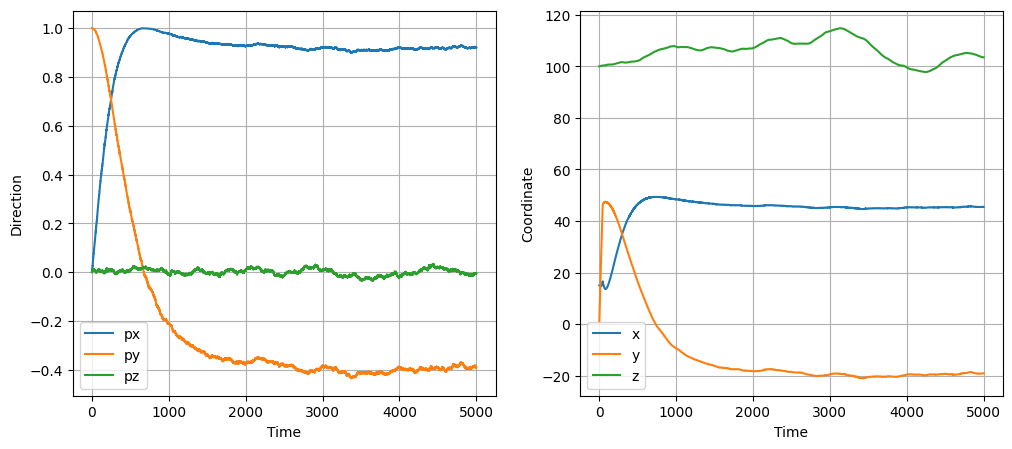

In [194]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(t, p_sol[:,0], label='px')
axs[0].plot(t, p_sol[:,1], label='py')
axs[0].plot(t, p_sol[:,2], label='pz')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Direction')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, R_sol[:,0], label='x')
axs[1].plot(t, R_sol[:,1], label='y')
axs[1].plot(t, R_sol[:,2], label='z')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Coordinate')
axs[1].legend()
axs[1].grid(True)


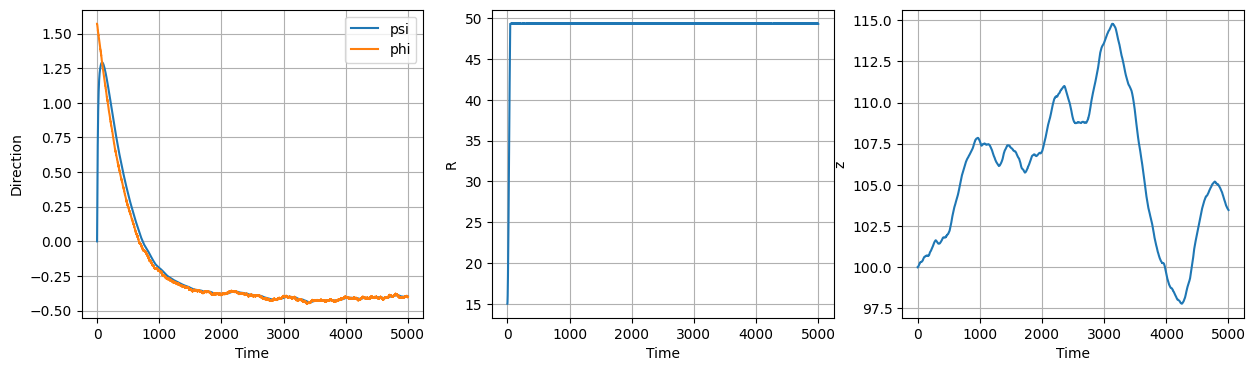

In [195]:
psi = np.arctan2(R_sol[:, 1], R_sol[:, 0])
phi = np.arctan2(p_sol[:, 1], p_sol[:, 0])
r = np.linalg.norm(R_sol[:, :2], axis=1)

fig, axs = plt.subplots(1, 3, figsize = (15,4))

axs[0].plot(t, psi, label=f'psi')
axs[0].plot(t, phi, label=f'phi')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Direction')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, r)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('R')
axs[1].grid(True)

axs[2].plot(t, R_sol[:,2])
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z')
axs[2].grid(True)

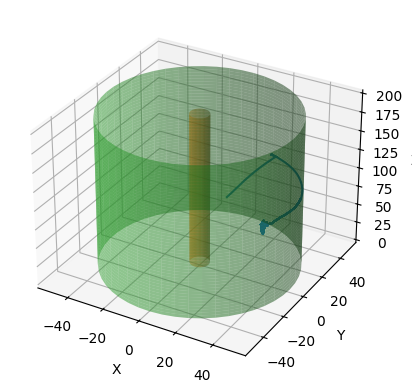

In [196]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(R_sol[:, 0], R_sol[:, 1], R_sol[:, 2])

X1,Y1,Z1 = data_for_cylinder_along_z(R1, L, 0)
ax.plot_surface(X1, Y1, Z1, alpha=0.5)

X2,Y2,Z2 = data_for_cylinder_along_z(R2, L, 0)
ax.plot_surface(X2, Y2, Z2, alpha=0.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


plt.show()

In [16]:
def U(phi):
    return - A * phi - np.cos(phi) / 2 / beta

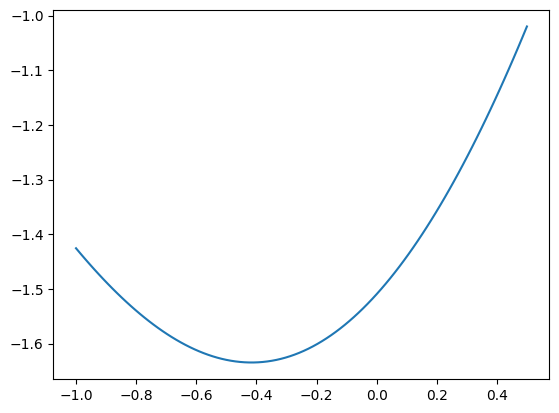

In [17]:
phis = np.linspace(-1, 0.5, 100)
plt.plot(phis, U(phis)/alpha)

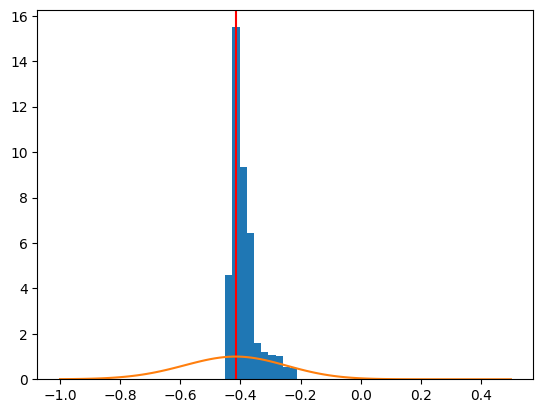

In [197]:
plt.hist(phi[10000:],  density=True)

phi_star = np.arcsin(2 * A * beta)

plt.axvline(phi_star, color = 'r')


phis = np.linspace(-1, 0.5, 100)
#plt.plot(phis, np.exp(-U(phis)/alpha * 1e1));
#plt.plot(phis, np.exp((-U(phis) + U(phi_star))/alpha ));
plt.plot(phis, np.exp((-U(phis) + U(phi_star))/D_R ));

In [154]:
def solver(new, N, p0s, R0s, dt, T, noise = False):
    ps = [[] for _ in range(N)]
    Rs = [[] for _ in range(N)]
    for i in range(N):
        ps[i].append(p0s[i])
        Rs[i].append(R0s[i])
    time = [0]
    t = 0
    while t < T:
        last = np.array([row[-1] for row in Rs])
        search = KDTree(last)
        for i in range(N):
            neighs = last[search.query_ball_point(last[i], 3 * sigma_part)]
            p_n, R_n = new(ps[i][-1], Rs[i][-1], dot, dt, t, noise, neighs)
            if np.linalg.norm(R_n[:2]) > R2:
                R_n[0] = R_n[0]/np.linalg.norm(R_n[:2]) * R2
                R_n[1] = R_n[1]/np.linalg.norm(R_n[:2]) * R2
            R_n[2] = R_n[2] % L
            ps[i].append(p_n)
            Rs[i].append(R_n)
        t += dt
        time.append(t)
    return np.array(ps), np.array(Rs), time

In [96]:
#R0s = np.array([[15 * R, 0, 0.5 * L], [10 * R, 0, 0.5 * L], [10 * R, 0, 0.75 * L]])
N = 3
R0s = np.array([[15 * R, 0, 0.5 * L], [10 * R, 0, 0.5 * L], [10 * R, 0, 0.55 * L]])
p0s = np.array([[0, 1, 0], [1, 0, 0], [0, 0, -1]])


ps_sol, Rs_sol, t = solver(euler, N, p0s, R0s, 0.1, 5000, noise = False)

In [85]:
print(Rs_sol[:][:,-1])

[[ 45.15687134 -19.87065816 100.80504064]
 [ 45.14005374 -19.86420972  98.8051228 ]
 [ 45.14013944 -19.86401498  67.19639438]
 [ 45.14005374 -19.86420972 109.77463543]]


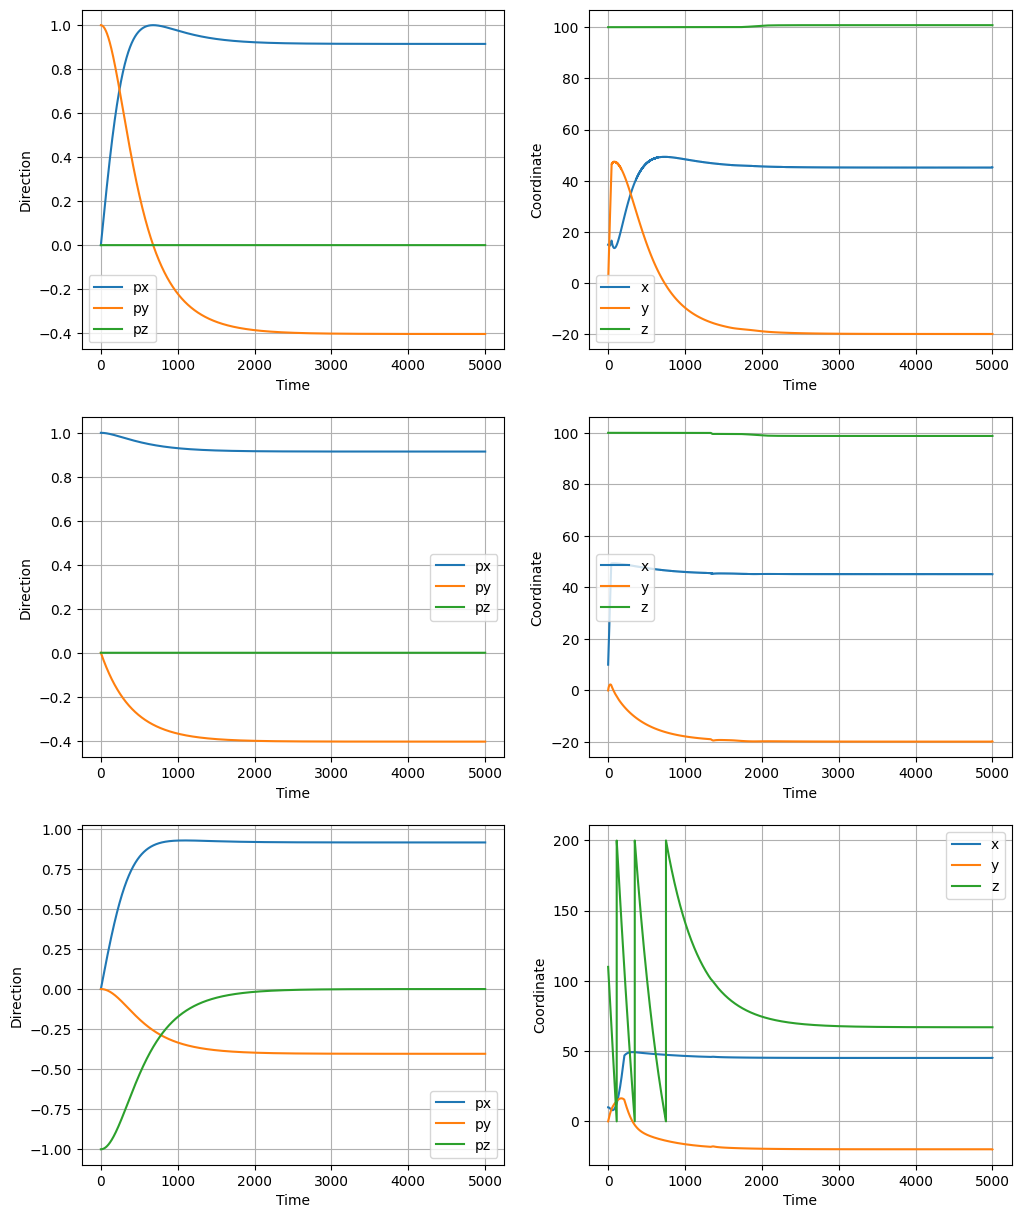

In [75]:
fig, axs = plt.subplots(N, 2, figsize = (12, 5 * N))

for i in range(N):
    axs[i][0].plot(t, ps_sol[i][:,0], label='px')
    axs[i][0].plot(t, ps_sol[i][:,1], label='py')
    axs[i][0].plot(t, ps_sol[i][:,2], label='pz')
    axs[i][0].set_xlabel('Time')
    axs[i][0].set_ylabel('Direction')
    axs[i][0].legend()
    axs[i][0].grid(True)

    axs[i][1].plot(t, Rs_sol[i][:,0], label='x')
    axs[i][1].plot(t, Rs_sol[i][:,1], label='y')
    axs[i][1].plot(t, Rs_sol[i][:,2], label='z')
    axs[i][1].set_xlabel('Time')
    axs[i][1].set_ylabel('Coordinate')
    axs[i][1].legend()
    axs[i][1].grid(True)


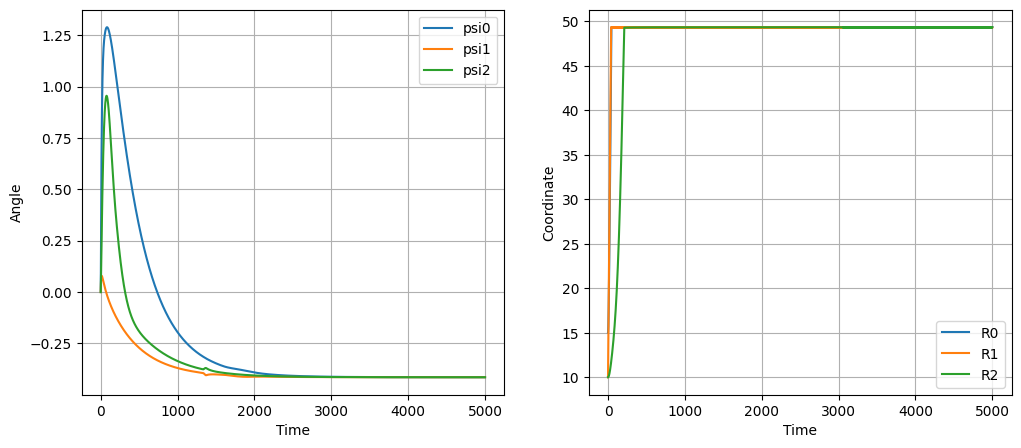

In [76]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))


for i in range(N):
    psi = np.arctan2(Rs_sol[i][:, 1], Rs_sol[i][:, 0])
    phi = np.arctan2(ps_sol[i][:, 1], ps_sol[i][:, 0])
    r = np.linalg.norm(Rs_sol[i][:, :2], axis=1)
    
    axs[0].plot(t, psi, label=f'psi{i}')
    #axs[0].plot(t, phi, label=f'phi{i}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Angle')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(t, r, label=f'R{i}')
    #axs[1].plot(t, Rs_sol[i][:,2], label=f'z{i}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Coordinate')
    axs[1].legend()
    axs[1].grid(True)

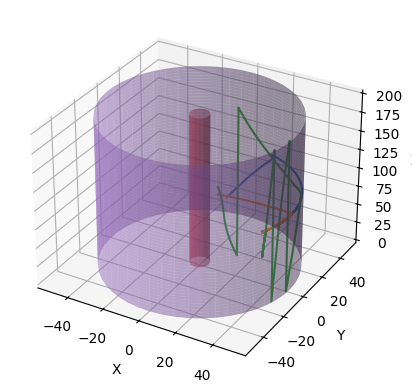

In [97]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(N):
    ax.plot(Rs_sol[i][:, 0], Rs_sol[i][:, 1], Rs_sol[i][:, 2])

X1,Y1,Z1 = data_for_cylinder_along_z(R1, L, 0)
ax.plot_surface(X1, Y1, Z1, alpha=0.5)

X2,Y2,Z2 = data_for_cylinder_along_z(R2, L, 0)
ax.plot_surface(X2, Y2, Z2, alpha=0.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


plt.show()

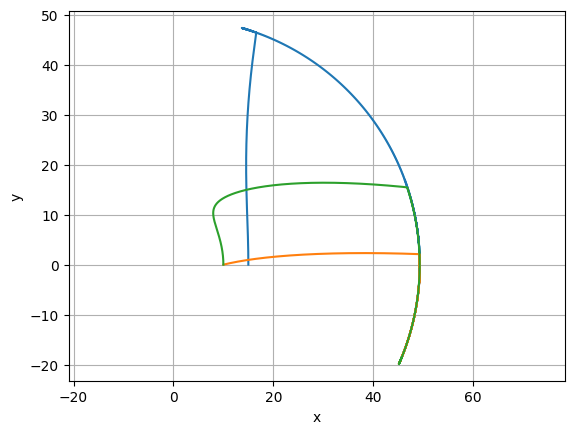

In [98]:
fig, axs = plt.subplots()

for i in range(N):
    axs.plot(Rs_sol[i][:,0], Rs_sol[i][:,1], label=f'i')
    #axs[i][1].plot(t, Rs_sol[i][:,2], label='z')
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.grid(True)
    #plt.plot(Rs_sol[i][:,-1])
axs.axis('equal');

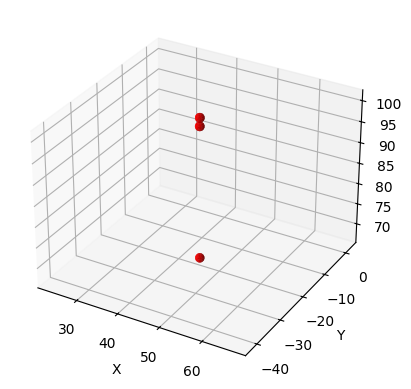

In [99]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(N):
    X, Y, Z = makesphere(Rs_sol[i][-1, 0], Rs_sol[i][-1, 1], Rs_sol[i][-1, 2], R)
    ax.plot_surface(X, Y, Z, color="r")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.axis('equal');

plt.show()

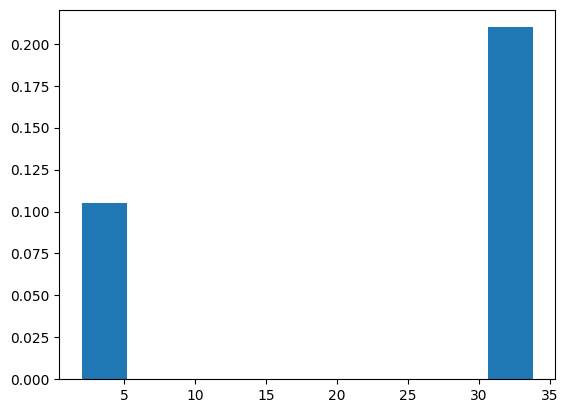

In [101]:
dist = distance_matrix(Rs_sol[:][:,-1],Rs_sol[:][:,-1])
dist[np.triu_indices(N, k = 1)]
plt.hist(dist[np.triu_indices(N, k = 1)],  density=True);

In [261]:
N = 100
zs = np.random.uniform(0, L, N)
psis = np.random.uniform(0, 2*np.pi, N)
Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
vecs = np.random.normal(size = (N, 3))
R0s = []
p0s = []
for i in range(N):
    R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
    p0s.append(vecs[i]/np.linalg.norm(vecs[i]))

ps_sol, Rs_sol, t = solver(euler, N, np.array(p0s), np.array(R0s), 0.1, 5000, noise = False)

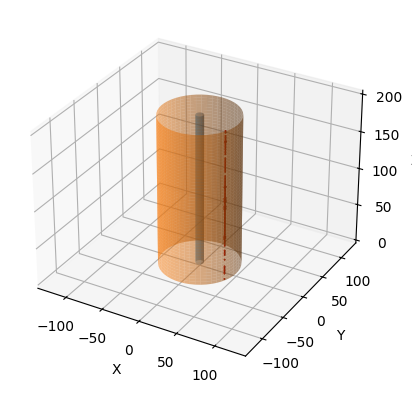

In [262]:
plot_state(Rs_sol[:][:,-1])

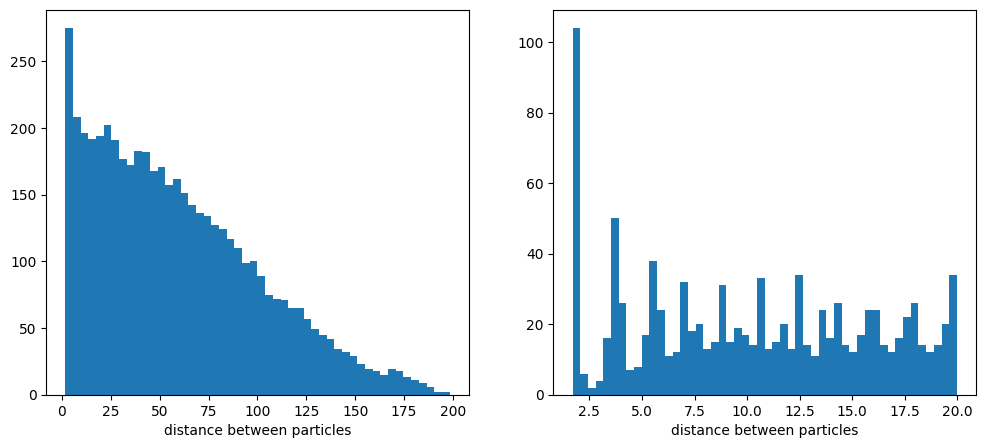

In [263]:
plot_dist(Rs_sol, 20 * R, 50)

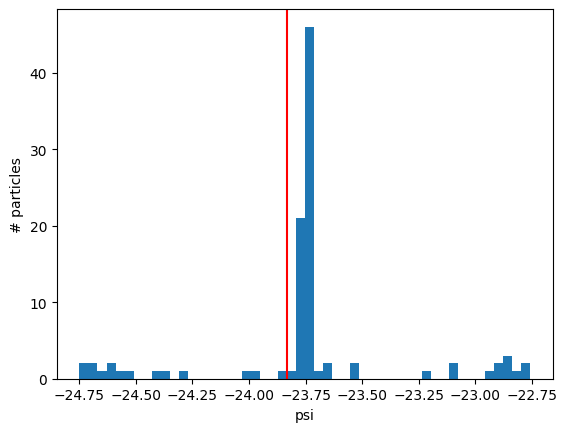

In [264]:
plot_angle(Rs_sol, 50)

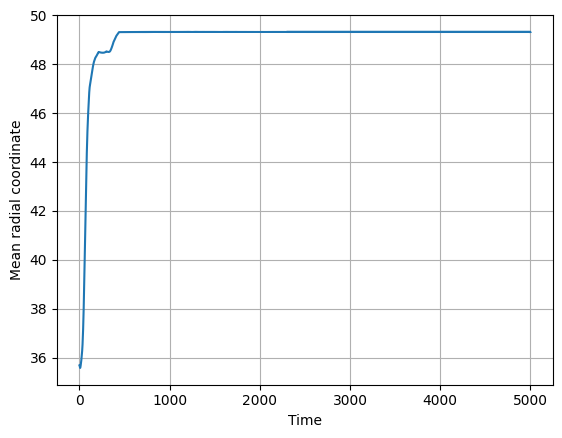

In [267]:
plot_R_mean(Rs_sol)

In [189]:
ps_sol_noisy, Rs_sol_noisy, t_noisy = solver(euler, N, np.array(p0s), np.array(R0s), 0.1, 5000, noise = True)

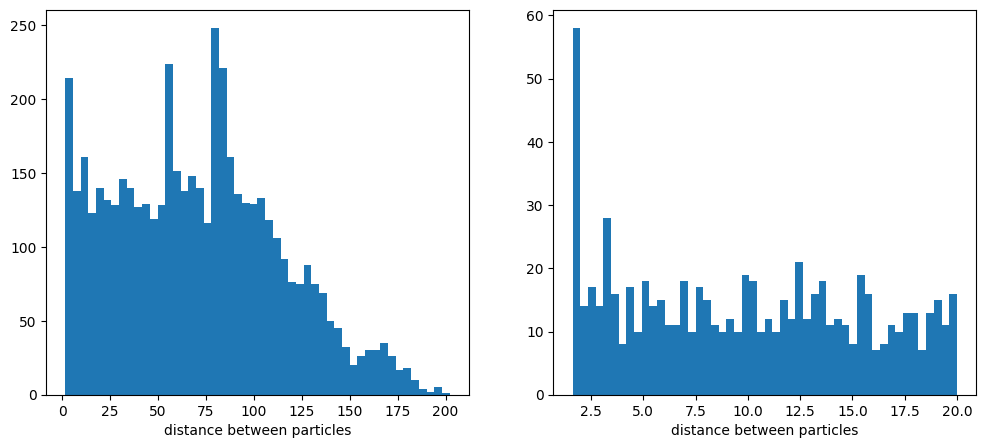

In [268]:
plot_dist(Rs_sol_noisy, 20 * R, 50)

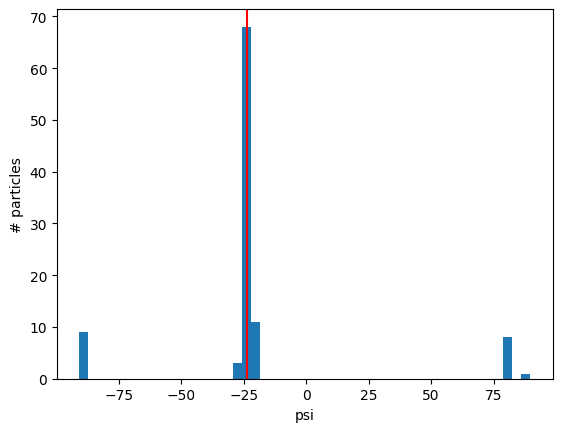

In [269]:
plot_angle(Rs_sol_noisy, 50)

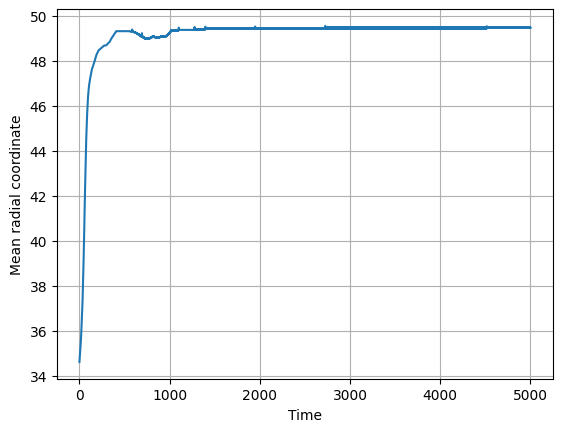

In [271]:
plot_R_mean(Rs_sol_noisy)

TODO:
- doc for one particle
- Video
- Cut-off at $3\sigma$
- Neighbor lists scipy KDTree?
- Particle distances for 100 hist
- Cluster finding
- smaller timestep
- distance distribution over time
- dynamic regime
- projection at the end
  